## This notebook creates a basic time series model for analysing the amount of trips by time period, and calculates the difference between summer and winter demand

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Import Data
df = pd.read_csv("C:/Data/Citibike_NY_2022/merged/df_weather.csv", index_col = False)
# Making sure date is datetime and df is sorted by date
df = df.sort_values('date')
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.head()

,date,temperature,precipitation,wind,trip_count
209,2022-01-01,11.6,193,28,20198
81,2022-01-02,11.4,10,43,42203
237,2022-01-03,1.4,0,64,32453
210,2022-01-04,-2.7,0,39,35869
82,2022-01-05,3.2,61,34,33689


In [4]:
# Setting date as index
df.set_index('date', inplace=True)

<Axes: xlabel='date'>

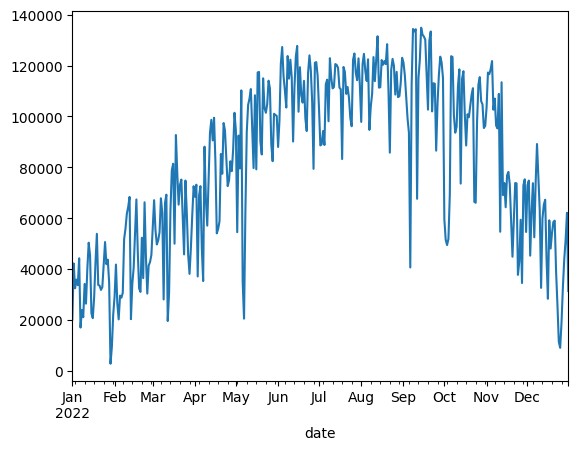

In [5]:
# Simple plot to look at the values 
df['trip_count'].plot()

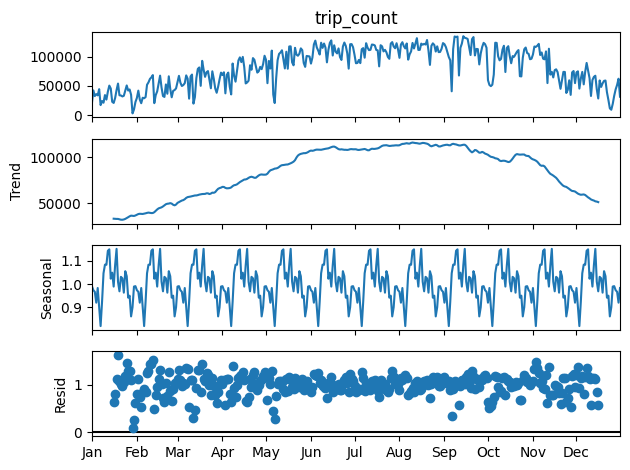

In [6]:
# decomposition of trip count
result = seasonal_decompose(df['trip_count'], model='multiplicative', period=30)  # monthly

fig = result.plot()
ax = fig.gca()

# Format x-axis to show only year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.show()

In [7]:
# getting monthly averages for trips 
monthly_avg = df['trip_count'].resample('ME').mean().astype(int)
print(monthly_avg)

date
2022-01-31     32739
2022-02-28     42682
2022-03-31     59491
2022-04-30     75300
2022-05-31     92301
2022-06-30    111261
2022-07-31    109305
2022-08-31    115031
2022-09-30    113471
2022-10-31     94507
2022-11-30     79334
2022-12-31     51197
Freq: ME, Name: trip_count, dtype: int64


In [8]:
# Monthly maxes 
monthly_max = df['trip_count'].resample('ME').max().astype(int)
print(monthly_max)

date
2022-01-31     53858
2022-02-28     68357
2022-03-31     92687
2022-04-30    101420
2022-05-31    117463
2022-06-30    127694
2022-07-31    124724
2022-08-31    131501
2022-09-30    134851
2022-10-31    123660
2022-11-30    121749
2022-12-31     89149
Freq: ME, Name: trip_count, dtype: int64


In [9]:
# Calculating how much to reduce capacities

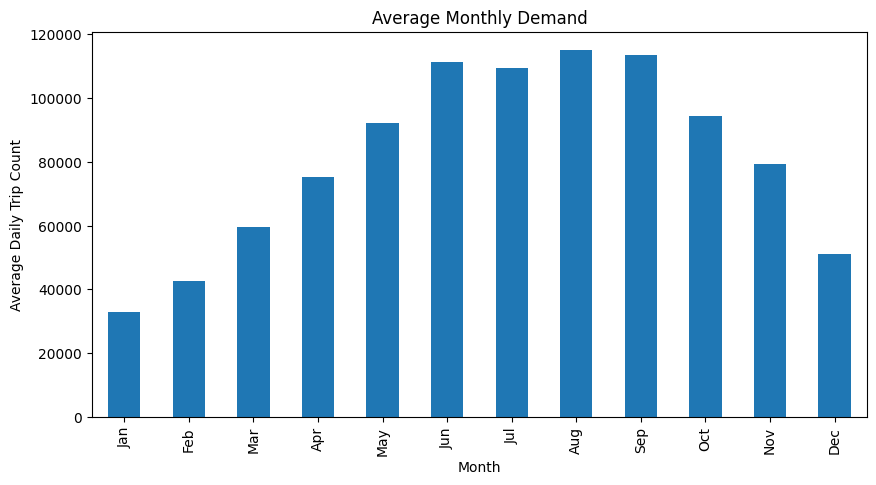

In [10]:
# Plotting average daily trips by month
fig, ax = plt.subplots(figsize=(10,5))
monthly_avg.plot(kind='bar', ax=ax)

ax.set_title("Average Monthly Demand")
ax.set_ylabel("Average Daily Trip Count")
ax.set_xlabel("Month")

# Abbreviated months for xticks
ax.set_xticklabels([d.strftime('%b') for d in monthly_avg.index])

plt.show()

In [11]:
monthly_avg.head()

date
2022-01-31    32739
2022-02-28    42682
2022-03-31    59491
2022-04-30    75300
2022-05-31    92301
Freq: ME, Name: trip_count, dtype: int64

Checking difference between peak months and low months (june-Aug vs Dec-Feb)

In [14]:
# Getting monthly averages in df with month as index
monthly_avg_df = monthly_avg.to_frame(name='trip_count')
monthly_avg_df['month'] = monthly_avg_df.index.month

# Map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

monthly_avg_df['season'] = monthly_avg_df['month'].apply(get_season)

# Compute seasonal means
seasonal_avg = monthly_avg_df.groupby('season')['trip_count'].mean().astype(int)

season_order = ['Spring', 'Summer', 'Autumn', 'Winter']

# Reorder the Series
seasonal_avg = seasonal_avg.reindex(season_order)
print(seasonal_avg)

season
Spring     75697
Summer    111865
Autumn     95770
Winter     42206
Name: trip_count, dtype: int64


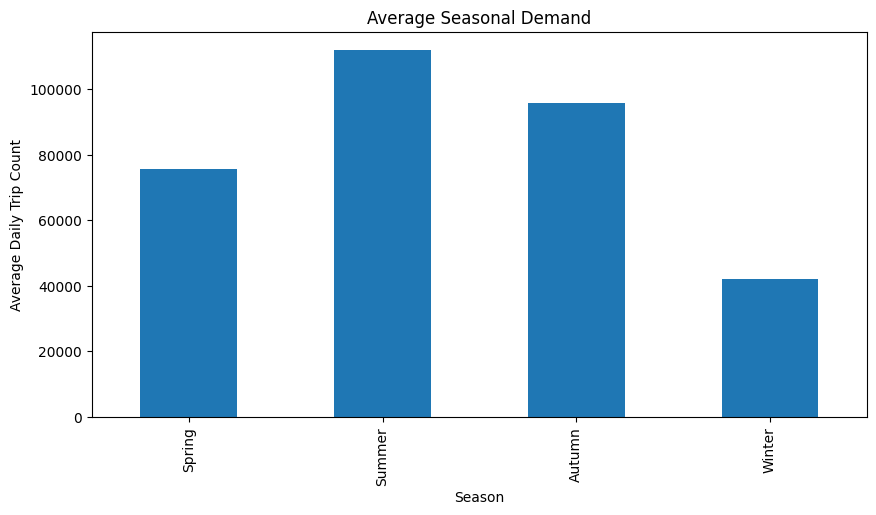

In [15]:
# Plotting average daily trips by season
fig, ax = plt.subplots(figsize=(10,5))
seasonal_avg.plot(kind='bar', ax=ax)

ax.set_title("Average Seasonal Demand")
ax.set_ylabel("Average Daily Trip Count")
ax.set_xlabel("Season")

plt.show()

In [28]:
# Checking difference between peak and low seasons
demand_difference = (seasonal_avg.loc['Winter']/seasonal_avg.loc['Summer'])-1
print(demand_difference)

-0.6227059401957717


With demand 62% lower on average in Winter than summer, we could afford to reduce our summer capacities by half and still have a 10% buffer

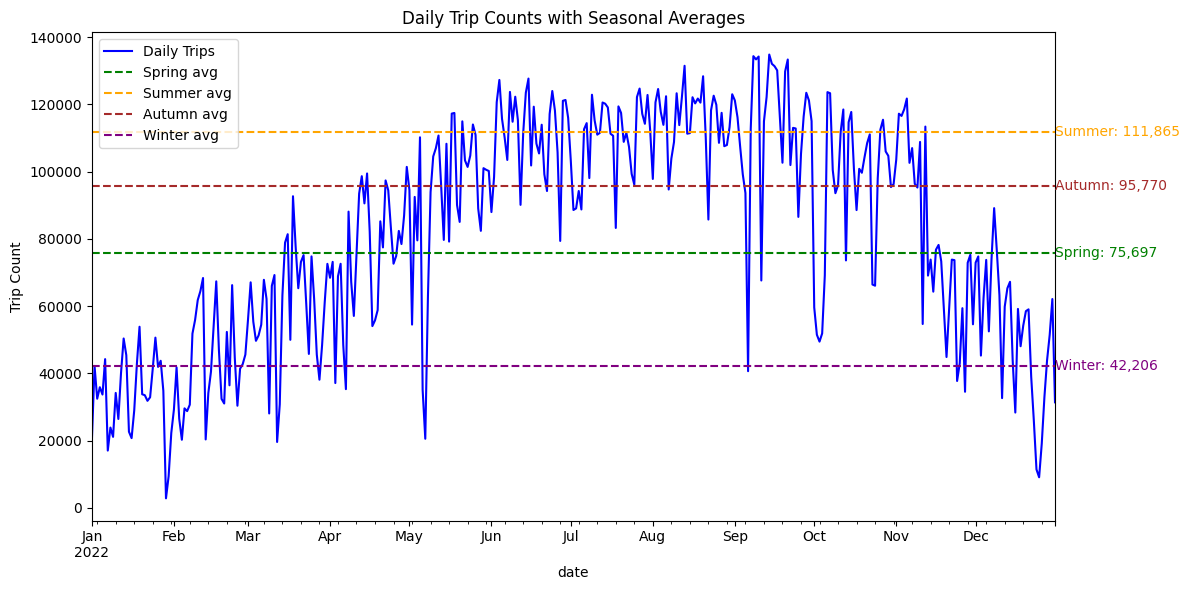

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot daily trip counts
df['trip_count'].plot(ax=ax, label='Daily Trips', color='blue')

# Add horizontal lines for each season's average
season_colors = {'Spring': 'green', 'Summer': 'orange', 'Autumn': 'brown', 'Winter': 'purple'}
for season, avg in seasonal_avg.items():
    ax.hlines(y=avg, xmin=df.index.min(), xmax=df.index.max(),
              colors=season_colors[season], linestyles='dashed', label=f'{season} avg')
    # Annotate the average value
    ax.text(df.index[-1], avg, f'{season}: {avg:,}', va='center', ha='left', color=season_colors[season], fontsize=10)

ax.set_title("Daily Trip Counts with Seasonal Averages")
ax.set_ylabel("Trip Count")
ax.legend()
plt.tight_layout()
plt.show()

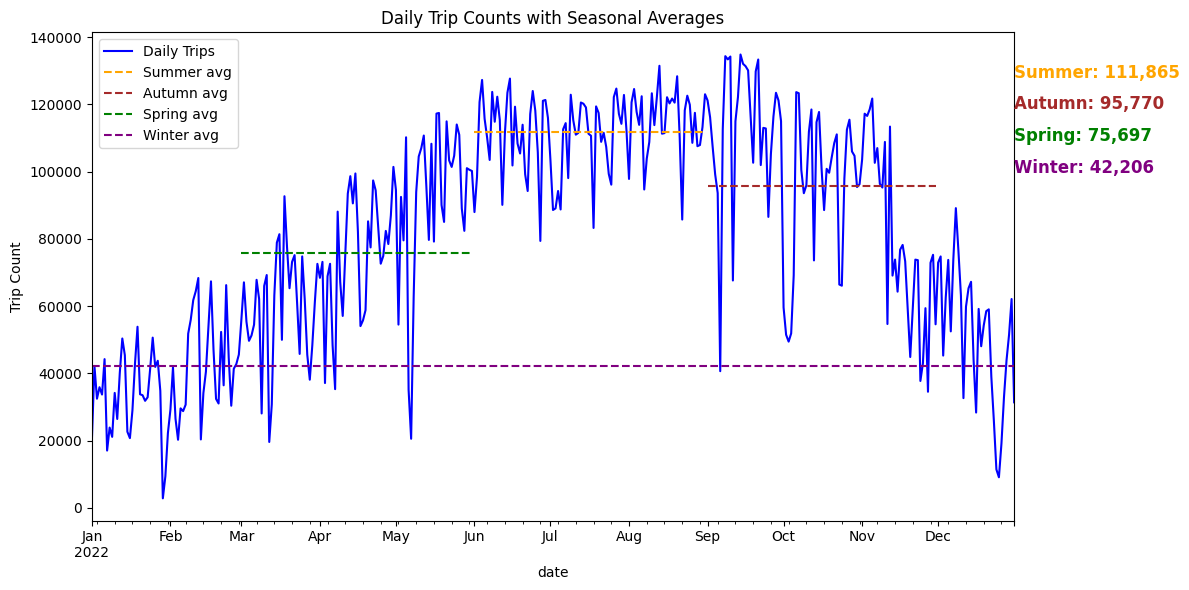

In [19]:
# Sort seasonal_avg from highest to lowest
seasonal_avg_sorted = seasonal_avg.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot daily trip counts
df['trip_count'].plot(ax=ax, label='Daily Trips', color='blue')

# Define season months and colors
season_months = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}
season_colors = {'Spring': 'green', 'Summer': 'orange', 'Autumn': 'brown', 'Winter': 'purple'}

# Calculate annotation positions
right_x = df.index.max()
y_start = df['trip_count'].max() * 0.98
y_offset = df['trip_count'].max() * 0.07

for i, (season, avg) in enumerate(seasonal_avg_sorted.items()):
    # Draw the horizontal line for the season
    months = season_months[season]
    season_dates = df.index[df.index.month.isin(months)]
    if len(season_dates) == 0:
        continue
    start = season_dates.min()
    end = season_dates.max()
    ax.hlines(y=avg, xmin=start, xmax=end,
              colors=season_colors[season], linestyles='dashed', label=f'{season} avg')
    # Annotate at the right, stacked vertically from top (highest value)
    y_annot = y_start - i * y_offset
    ax.text(right_x, y_annot, f"{season}: {avg:,}", va='top', ha='left', color=season_colors[season], fontsize=12, fontweight='bold')

ax.set_title("Daily Trip Counts with Seasonal Averages")
ax.set_ylabel("Trip Count")
ax.legend()
plt.tight_layout()
plt.show()

In [21]:
fig.savefig("../visualisations/season_annotated.png", dpi=150, bbox_inches="tight")